In [4]:
!gsutil cp gs://chem_dsrc/ZebrafishBehavior/All_alive_labeling_tvt.zip ./

Copying gs://chem_dsrc/ZebrafishBehavior/All_alive_labeling_tvt.zip...
/ [1 files][  6.6 MiB/  6.6 MiB]                                                
Operation completed over 1 objects/6.6 MiB.                                      


In [5]:
!unzip All_alive_labeling_tvt.zip

Archive:  All_alive_labeling_tvt.zip
   creating: All_alive_labeling_tvt/test/
   creating: All_alive_labeling_tvt/test/100ppm/
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm(2)07.png  
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm(2)09.png  
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm(2)18.png  
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm(2)20.png  
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm04.png  
 extracting: All_alive_labeling_tvt/test/100ppm/100ppm06.png  
 extracting: All_alive_labeling_tvt/test/100ppm/100ppm08.png  
 extracting: All_alive_labeling_tvt/test/100ppm/100ppm12.png  
  inflating: All_alive_labeling_tvt/test/100ppm/100ppm18.png  
   creating: All_alive_labeling_tvt/test/10ppm/
  inflating: All_alive_labeling_tvt/test/10ppm/10ppm(2)01.png  
  inflating: All_alive_labeling_tvt/test/10ppm/10ppm(2)08.png  
  inflating: All_alive_labeling_tvt/test/10ppm/10ppm(2)11.png  
  inflating: All_alive_labeling_tvt/test/10ppm/10ppm(

# Import VGG16 model

In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape=(180,180,3))
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
______________________________________________________________

# feature extract
ImageDataGenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출

conv_base모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
# dir_path = 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/'
dir_path = '/content/All_alive_labeling_tvt/'
train_dir = dir_path +'train'
validation_dir = dir_path+'/validation'
test_dir = dir_path + 'test'

# datagen = ImageDataGenerator(rescale=1./255) #이미지를 스케일링.
datagen = ImageDataGenerator() #이미지를 스케일링.
batch_size = 13

train_s_s = 1335 
val_s_s = 336
test_s_s = 442

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 512))#마지막 Max_pooling층이 (2,2,512)이므로
    labels = np.zeros(shape=(sample_count,13))#레이블이 저장될 ndarray
    generator = datagen.flow_from_directory(
        directory,
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, train_s_s)
validation_features, validation_labels = extract_features(validation_dir, val_s_s)
test_features, test_labels = extract_features(test_dir, test_s_s)

Found 1335 images belonging to 13 classes.
Found 336 images belonging to 13 classes.
Found 442 images belonging to 13 classes.


추출된 특성의 크기는 (samples, 2, 2, 512) 입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 2 *2 *512) 크기로 펼칩니다.

In [7]:
vgg16_output_size = 5*5*512
train_features = np.reshape(train_features, (train_s_s, vgg16_output_size ))
validation_features = np.reshape(validation_features, (val_s_s, vgg16_output_size ))
test_features = np.reshape(test_features, (test_s_s, vgg16_output_size ))

완전 연결 분류기 층을 한번더 거쳐서 최종 모델을 만들어낸다.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = vgg16_output_size))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(13, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=1000,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

model.save('All(alive)_vgg16_epoch1000.h5')

Epoch 1/1000
67/67 [==============================] - 1s 9ms/step - loss: 23.5156 - acc: 0.1880 - val_loss: 7.7246 - val_acc: 0.4137
Epoch 2/1000
67/67 [==============================] - 0s 6ms/step - loss: 13.2699 - acc: 0.3008 - val_loss: 5.8594 - val_acc: 0.4107
Epoch 3/1000
67/67 [==============================] - 0s 6ms/step - loss: 9.6508 - acc: 0.3105 - val_loss: 4.3236 - val_acc: 0.4643
Epoch 4/1000
67/67 [==============================] - 0s 6ms/step - loss: 7.1517 - acc: 0.3632 - val_loss: 3.3935 - val_acc: 0.4435
Epoch 5/1000
67/67 [==============================] - 0s 6ms/step - loss: 4.7854 - acc: 0.3642 - val_loss: 2.8982 - val_acc: 0.4613
Epoch 6/1000
67/67 [==============================] - 0s 6ms/step - loss: 3.9252 - acc: 0.3914 - val_loss: 2.6376 - val_acc: 0.4673
Epoch 7/1000
67/67 [==============================] - 0s 6ms/step - loss: 2.8133 - acc: 0.4116 - val_loss: 2.3626 - val_acc: 0.4673
Epoch 8/1000
67/67 [==============================] - 0s 6ms/step - loss: 

In [ ]:
그래프를 통해 훈련, 검증 과정을 살펴본다.

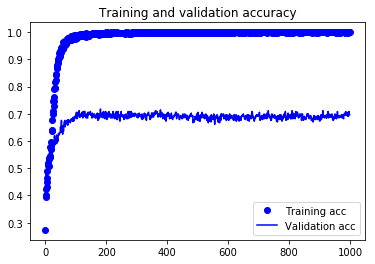

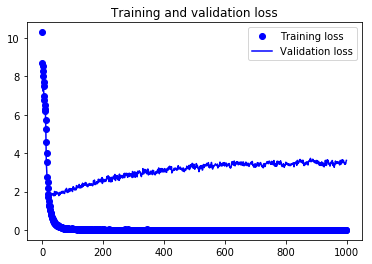

max train_acc : 0.9992509363742357
argmax : 520
min train_loss : 0.01207388582332073
argmin : 997

max val_acc : 0.7172619033427465
argmax : 181
min vla_loss : 1.7804259537231355
argmin : 39


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
train_acc =history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
train_loss =history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print('max train_acc : ' + str(np.asarray(train_acc).max()))
print('argmax : ' + str(np.asarray(train_acc).argmax()))
print('min train_loss : ' + str(np.asarray(train_loss).min()))
print('argmin : ' + str(np.asarray(train_loss).argmin()))

print()

print('max val_acc : ' + str(np.asarray(val_acc).max()))
print('argmax : ' + str(np.asarray(val_acc).argmax()))
print('min vla_loss : ' + str(np.asarray(val_loss).min()))
print('argmin : ' + str(np.asarray(val_loss).argmin()))

In [ ]:
scores = model.evaluate(test_features, test_labels)

442/442 [==============================] - 0s 239us/step


In [ ]:
print("%s : %.2f%%" %(model.metrics_names[1], scores[1]*100))

acc : 66.74%


Test_Acc는 augmenting하기 전이 더 높다 왜 그럴까?
agumenting과정에서 무언가 문제가 있는 것이 분명하다

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=180, #랜덤하게 사진을 회전시킬 각도 범위(0-180)
      #width_shift_range=0.2, # 수평으로 랜덤하게 평행 이동시킬 범위
      #height_shift_range=0.2, # 수직으로 랜덤하게 평행 이동시킬 범위
      shear_range=0.2, #랜덤하게 전단 변환을 적용할 각도 범위입니다.
      #zoom_range=0.2, # 랜덤하게 사진을 확대할 범위
      horizontal_flip=True, # 랜덤하게 이미지를 수평으로 뒤집는다.
      fill_mode='nearest' #회전이라 가로/세로 이동으로 인해 새롭게 생성해야 할 칙셀을 채울 전략.
)

In [ ]:
fnames

['F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\100ppm',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\10ppm',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\200ppm',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\BIT0.01',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\BIT0.1',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\BIT1',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\Pb0.5',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\bpa0.01',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\bpa0.1',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\bpa1',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\control',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\pb0.1',
 'F:/UOSEST/ZebraFish_data/All_alive_labeling_tvt/train\\sc']

In [ ]:
imgplot = plt.imshow(image.array_to_img(x))
plt.show()

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1, 80, 80, 3)

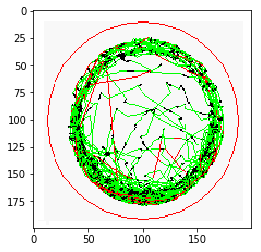

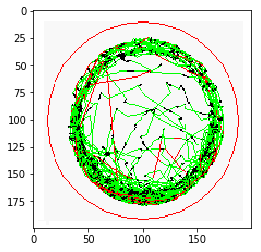

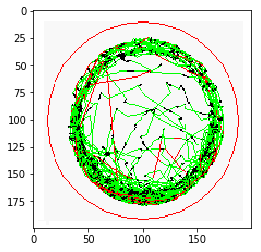

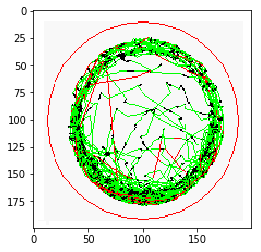

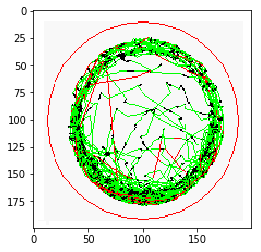

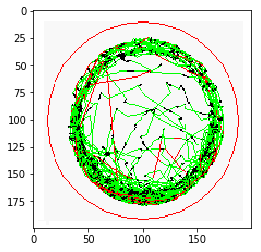

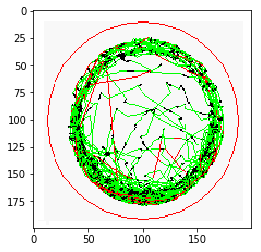

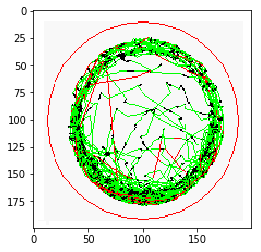

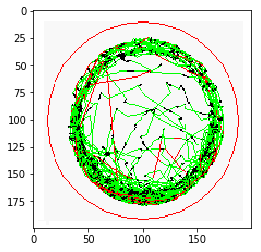

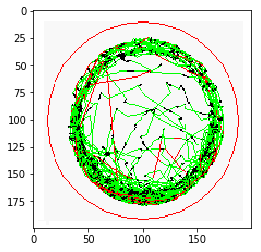

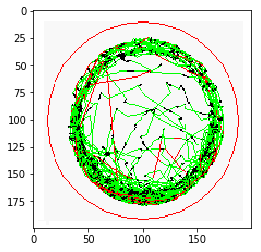

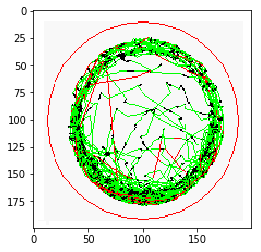

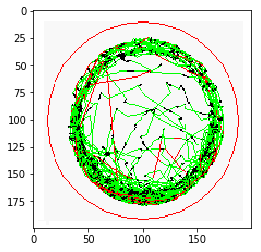

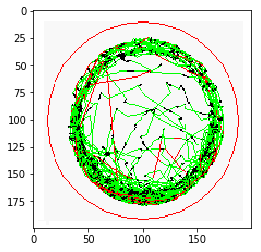

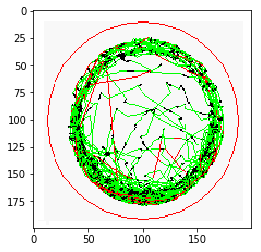

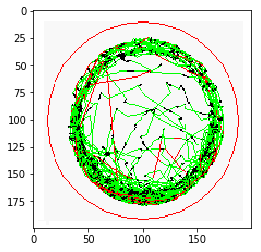

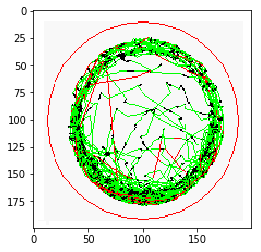

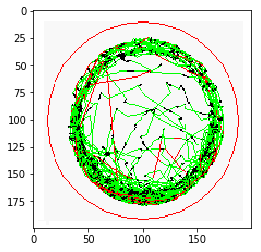

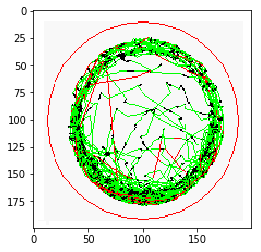

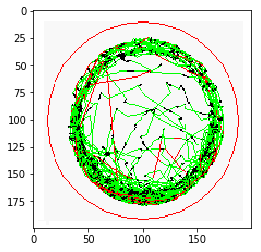

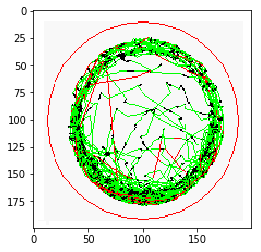

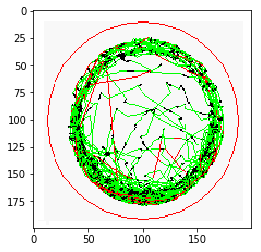

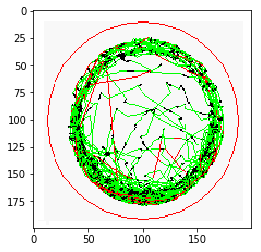

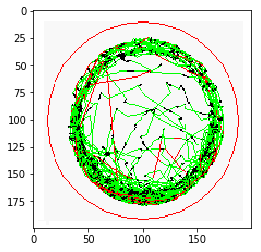

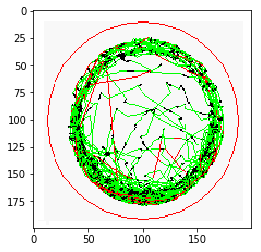

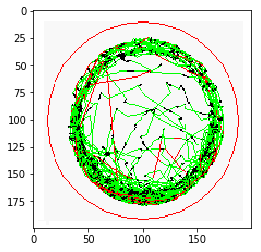

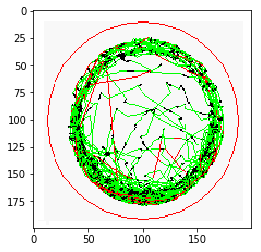

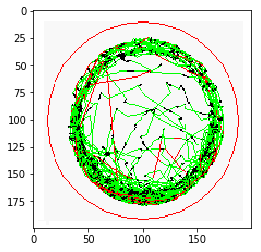

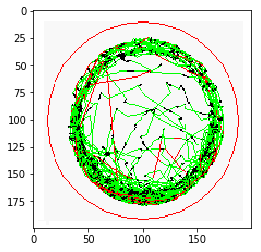

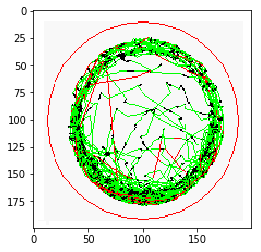

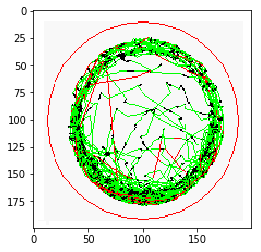

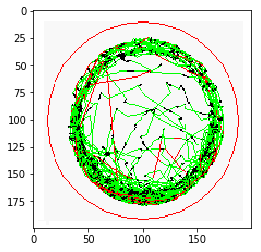

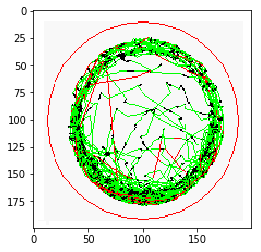

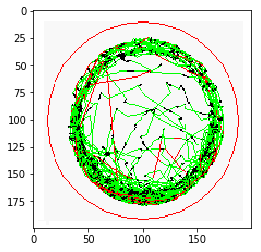

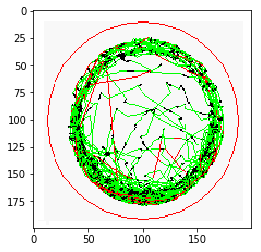

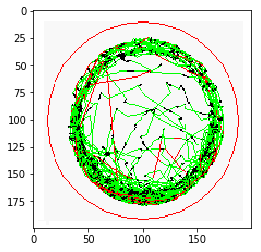

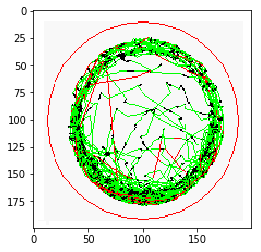

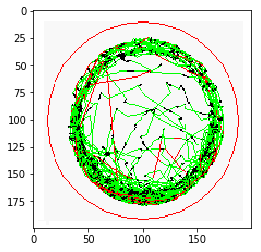

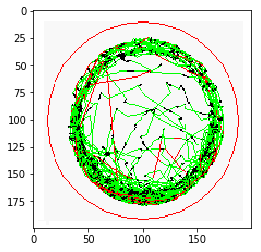

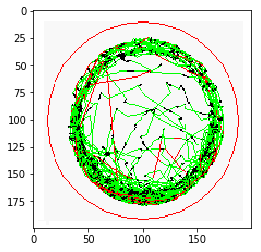

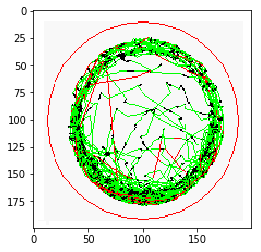

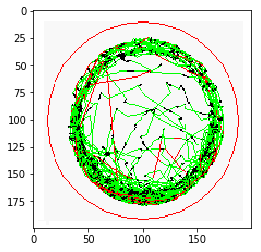

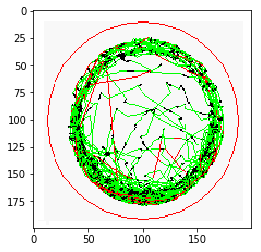

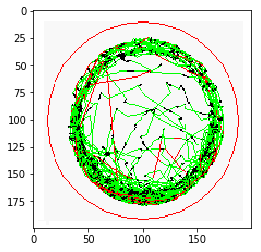

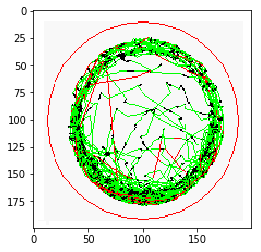

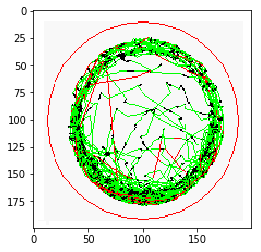

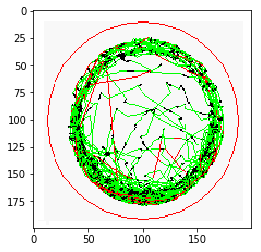

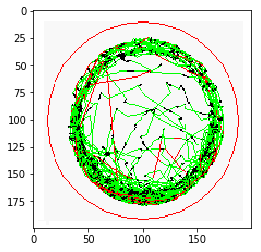

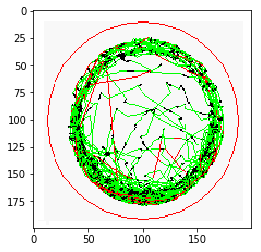

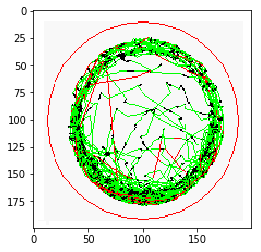

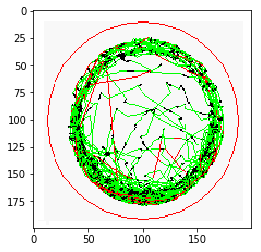

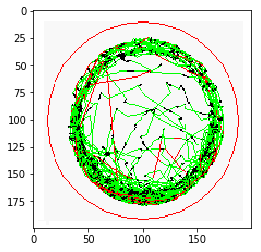

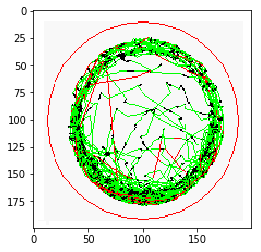

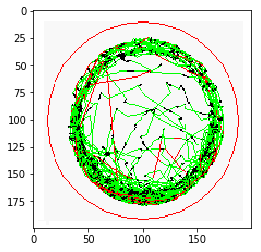

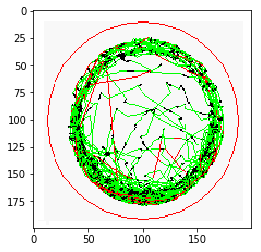

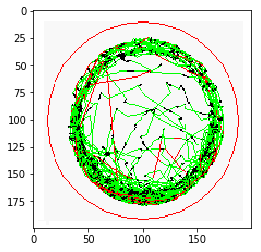

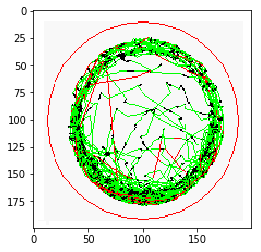

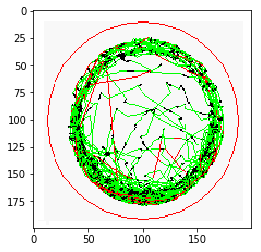

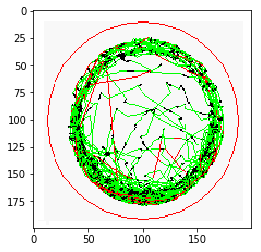

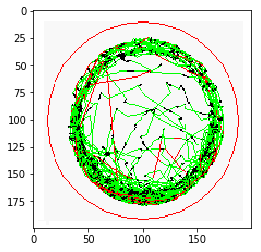

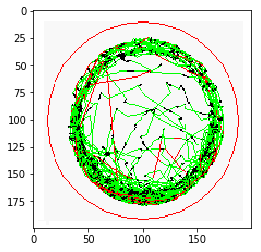

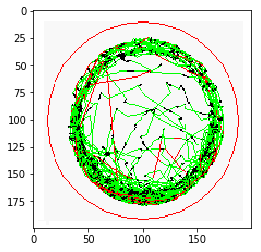

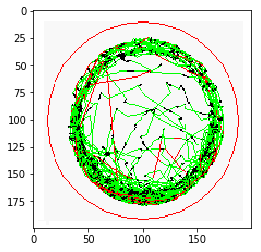

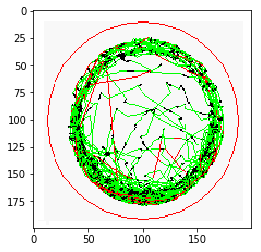

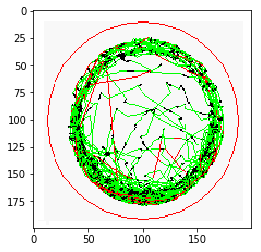

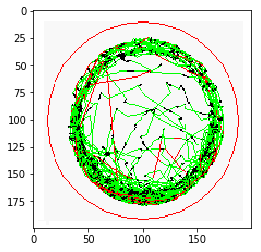

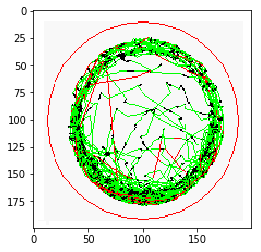

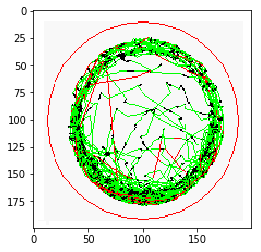

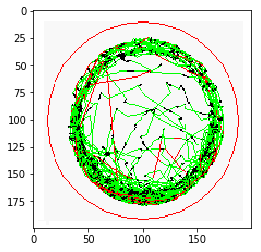

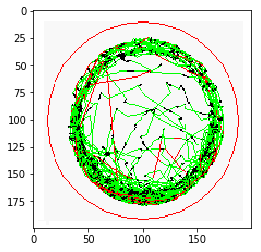

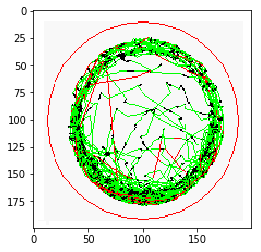

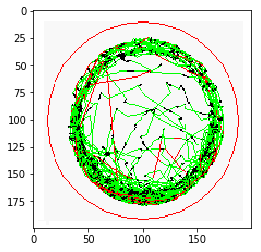

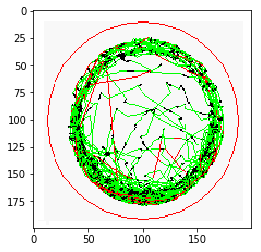

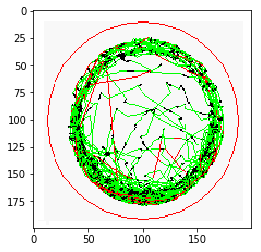

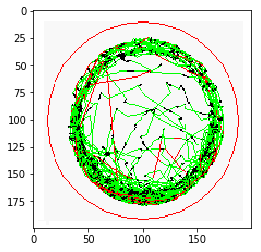

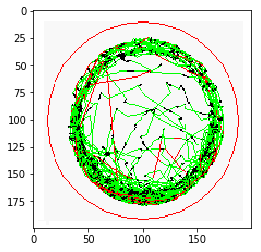

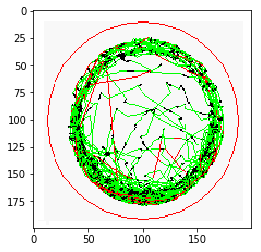

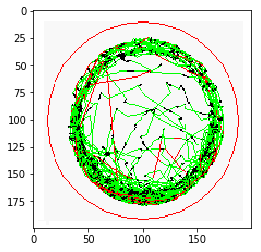

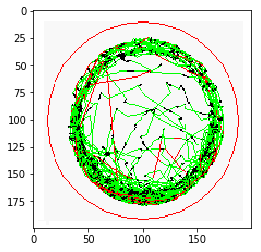

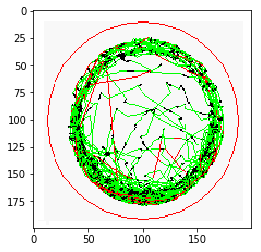

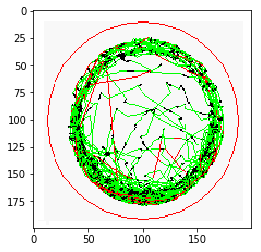

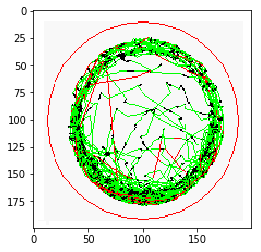

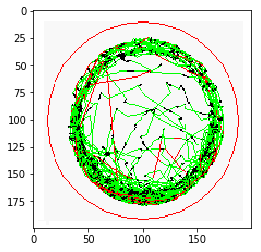

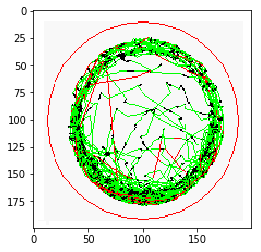

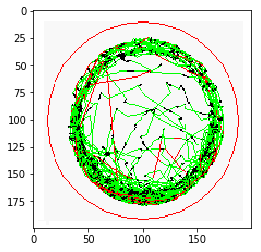

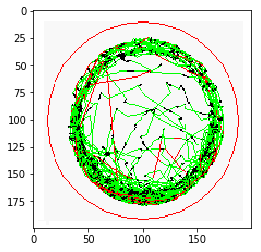

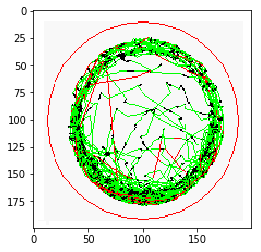

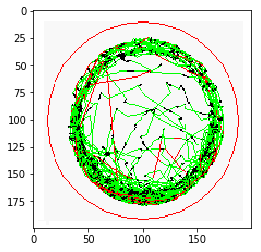

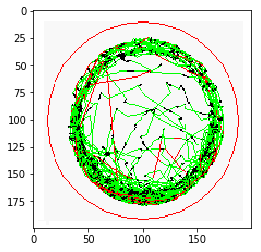

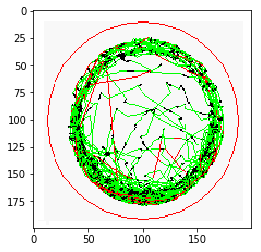

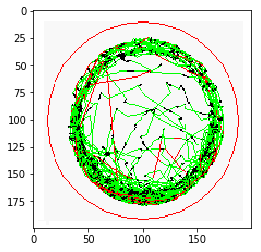

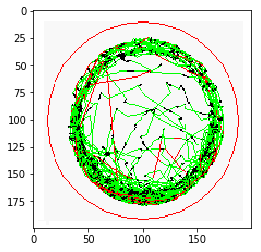

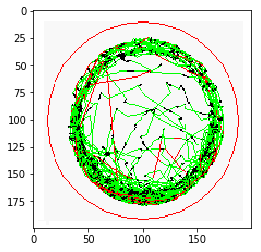

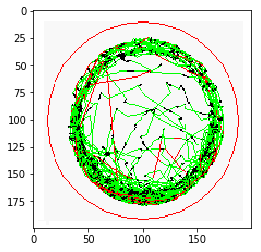

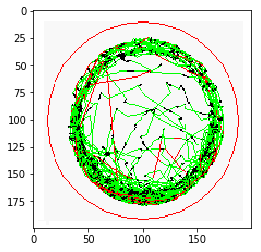

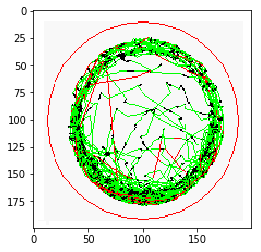

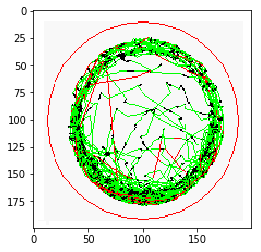

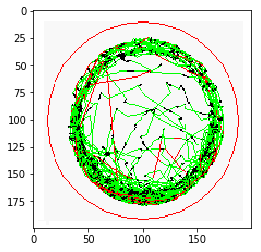

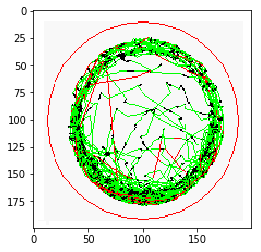

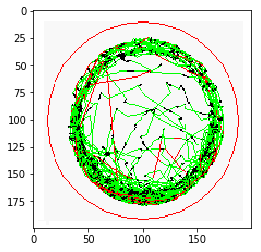

In [ ]:

# 이미지 전처리 유틸리티 모듈
from keras.preprocessing import image
train_cats_dir = train_dir + '/100ppm'
fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(200, 200))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 100  == 0:
        break

plt.show()